In [32]:
import pandas as pd
import numpy as np

In [33]:
#Load the matches that have already occurred
df = pd.read_csv("/content/ufc-master.csv")

#Load the upcoming matches
df_upcoming = pd.read_csv("/content/upcoming-event.csv")

#Get the number of upcoming fights
num_upcoming_fights = len(df_upcoming)
print(f"We are going to predict the winner of {num_upcoming_fights} fights.")

We are going to predict the winner of 13 fights.


In [34]:
# Combine the upcoming fights with the previous fights
df_combined = pd.concat([df_upcoming, df], ignore_index=True)

# Add a new column for labels
df_combined['label'] = ''

# Convert 'Red' and 'Blue' in the 'Winner' column to 0 and 1, respectively
df_combined.loc[df_combined['Winner'] == 'Red', 'label'] = 0
df_combined.loc[df_combined['Winner'] == 'Blue', 'label'] = 1

# Make sure label is numeric
df_combined['label'] = pd.to_numeric(df_combined['label'], errors='coerce')

# Make sure the date column is in datetime format
df_combined['date'] = pd.to_datetime(df_combined['date'])

In [35]:
#Copy the labels to their own dataframe
label_df = df_combined['label']

#Split the train set from the test set

df_train = df_combined[num_upcoming_fights:]
label_train = label_df[num_upcoming_fights:]

df_test = df_combined[:num_upcoming_fights]
label_test = label_df[:num_upcoming_fights]


#Make sure the sizes are the same
print(len(df_test))
print(len(label_test))

print(len(df_train))
print(len(label_train))

13
13
4256
4256


In [36]:
from sklearn.tree import DecisionTreeClassifier
#Pick a model
my_model = DecisionTreeClassifier(max_depth=5)

#Pick some features
#I would not recommend placing bets based off of these features...
my_features = ['R_odds', 'B_Stance']

#Let's grab the names of the fighters for the upcoming event
#This will be useful to print predictions at the end.
fighters_test = df_test[['R_fighter', 'B_fighter']]


#Make dataframes that only contain the relevant features
df_train_prepped = df_train[my_features].copy()
df_test_prepped = df_test[my_features].copy()

#If we need to dummify the datasets do it now.  We need to be careful that the test set has all of the features
#that the training set does

df_train_prepped = pd.get_dummies(df_train_prepped)
df_test_prepped = pd.get_dummies(df_test_prepped)

#Ensure both sets are dummified the same
df_train_prepped, df_test_prepped = df_train_prepped.align(df_test_prepped, join='left', axis=1)

#The new test set may have new new features after the above join.  Fill them with zeroes
df_test_prepped = df_test_prepped.fillna(0)

#Since we may have dropped some rows we need to drop the matching rows in the labels
label_train_prepped = label_train[label_train.index.isin(df_train_prepped.index)]
label_test_prepped = label_test[label_test.index.isin(df_test_prepped.index)]
fighters_test_prepped = fighters_test[fighters_test.index.isin(df_test_prepped.index)]


#Quick test that lengths match.
print(len(label_train_prepped))
print(len(df_train_prepped))
print(len(label_test_prepped))
print(len(df_test_prepped))
print(len(fighters_test_prepped))

4256
4256
13
13
13


In [37]:
#Train the model

my_model.fit(df_train_prepped, label_train_prepped)

DecisionTreeClassifier(max_depth=5)

In [38]:
# Get predictions from the model
predictions = my_model.predict(df_test_prepped).squeeze()  # Ensure predictions is 1D

# Ensure fighters_test_prepped contains pairs of fighters
fighters_array = fighters_test_prepped.to_numpy()

# Zip fighters and predictions together
prediction_list = list(zip(fighters_array, predictions))  # Keep as a list to avoid issues

# Print predictions
for fighter_pair, prediction in prediction_list:
    red_fighter, blue_fighter = fighter_pair  # Unpack the fighter pair
    if prediction == 0.0:  # Check for RED win
        print(f"RED fighter {red_fighter} is predicted to win over {blue_fighter}")
    else:  # Otherwise, BLUE win
        print(f"BLUE fighter {blue_fighter} is predicted to win over {red_fighter}")

RED fighter Kamaru Usman is predicted to win over Gilbert Burns
RED fighter Alexander Volkanovski is predicted to win over Max Holloway
RED fighter Petr Yan is predicted to win over Jose Aldo
BLUE fighter Rose Namajunas is predicted to win over Jessica Andrade
RED fighter Amanda Ribas is predicted to win over Paige VanZant
RED fighter Volkan Oezdemir is predicted to win over Jiri Prochazka
RED fighter Elizeu Zaleski dos Santos is predicted to win over Muslim Salikhov
RED fighter Makwan Amirkhani is predicted to win over Danny Henry
RED fighter Leonardo Santos is predicted to win over Roman Bogatov
RED fighter Marcin Tybura is predicted to win over Alexandr Romanov
RED fighter Raulian Paiva is predicted to win over Zhalgas Zhamagulov
RED fighter Karol Rosa is predicted to win over Vanessa Melo
RED fighter Martin Day is predicted to win over Davey Grant


## Visualizations

<ipython-input-39-87b2cf45804b>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Winner', palette='Set2')


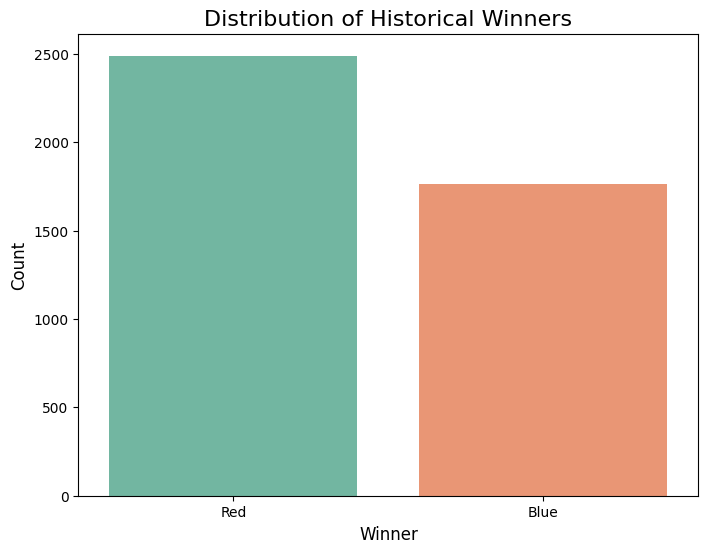

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of winners in historical data
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Winner', palette='Set2')
plt.title('Distribution of Historical Winners', fontsize=16)
plt.xlabel('Winner', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

<ipython-input-40-2be9f565a770>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Winner', y='R_odds', palette='coolwarm')


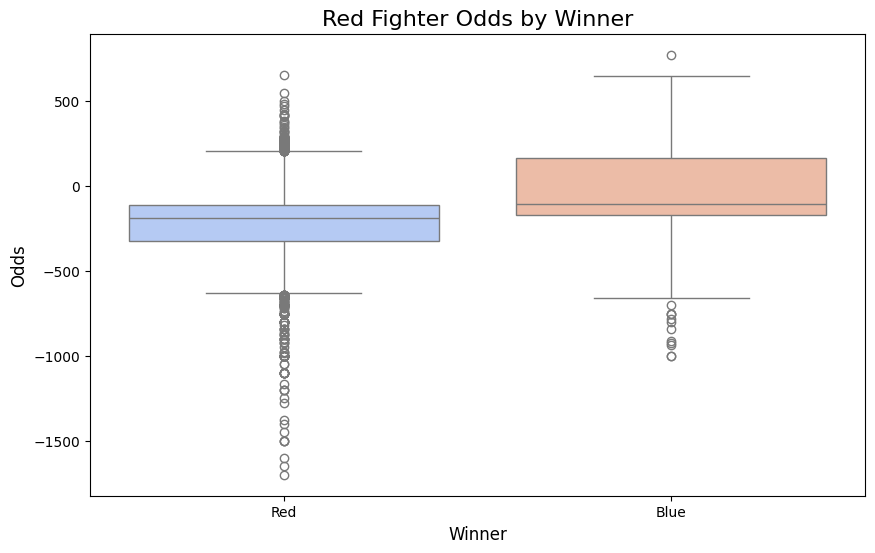

In [40]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Winner', y='R_odds', palette='coolwarm')
plt.title('Red Fighter Odds by Winner', fontsize=16)
plt.xlabel('Winner', fontsize=12)
plt.ylabel('Odds', fontsize=12)
plt.show()


<ipython-input-42-ea0168bef63a>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=predicted_counts.index, y=predicted_counts.values, palette='pastel')


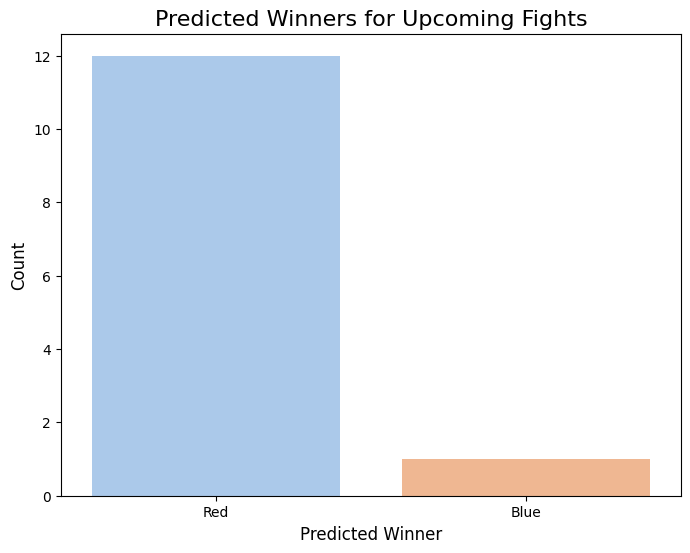

In [42]:
# Predicted winners for upcoming fights
predicted_counts = pd.Series(predictions).value_counts()
predicted_counts.index = ['Red', 'Blue']  # Map 0 -> Red, 1 -> Blue

plt.figure(figsize=(8, 6))
sns.barplot(x=predicted_counts.index, y=predicted_counts.values, palette='pastel')
plt.title('Predicted Winners for Upcoming Fights', fontsize=16)
plt.xlabel('Predicted Winner', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


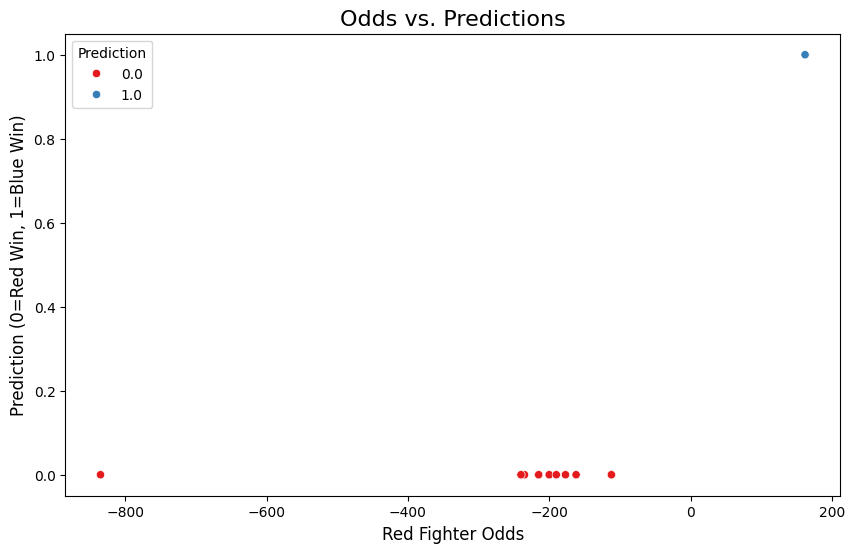

In [43]:
# Merge odds and predictions for visualization
df_test_prepped['Prediction'] = predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_test_prepped, x='R_odds', y='Prediction', hue='Prediction', palette='Set1')
plt.title('Odds vs. Predictions', fontsize=16)
plt.xlabel('Red Fighter Odds', fontsize=12)
plt.ylabel('Prediction (0=Red Win, 1=Blue Win)', fontsize=12)
plt.show()
